### Import Librairies

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

print(os.listdir())

['.DS_Store', 'sampleSubmission.csv', 'model2.h5', 'test1', 'train', 'model.h5', 'model1.h5', 'Dogs vs Cats.ipynb', '.ipynb_checkpoints', 'final_model.h5']


### Defining Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("train")

### Importing the Data

In [4]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


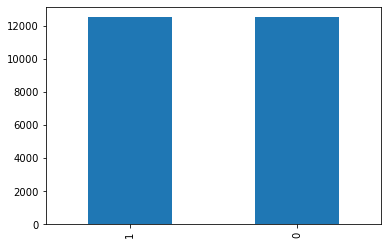

In [6]:
df['category'].value_counts().plot.bar()

### Random Train Sample

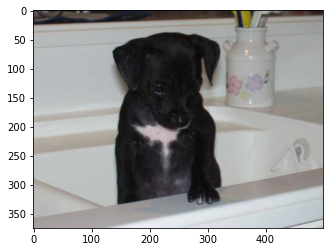

In [7]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

In [8]:
"""
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu',use_bias=True, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(512, activation = 'relu',use_bias=True))
model.add(Dense(2, activation = 'relu',use_bias=True))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
"""

"\nfrom keras.models import Sequential\nfrom keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization\nmodel = Sequential()\n\nmodel.add(Conv2D(64, (3, 3), activation='relu',use_bias=True, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Flatten())\n\nmodel.add(Dense(512, activation = 'relu',use_bias=True))\nmodel.add(Dense(2, activation = 'relu',use_bias=True))\nmodel.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])\nmodel.summary()\n"

## Building the CNN

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

### CallBacks and Learning Rate

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

### Preparing the Data

In [11]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [12]:
df

,filename,category
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat
...,...,...
24995,dog.8008.jpg,dog
24996,dog.1992.jpg,dog
24997,dog.12412.jpg,dog
24998,cat.2701.jpg,cat


In [13]:
train_df, validate_df = train_test_split(df, test_size=0.10, random_state=40)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

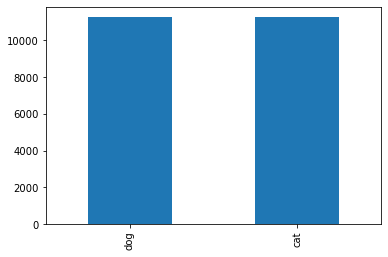

In [14]:
train_df['category'].value_counts().plot.bar()

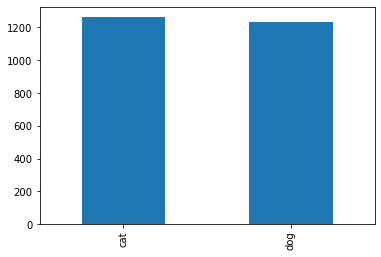

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Training and Validating Data Generator

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


### See how generator works

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


new


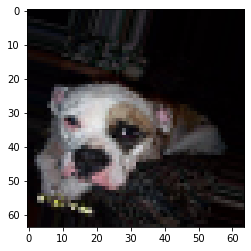

In [20]:
for X_batch, Y_batch in example_generator:
    print('new')
    plt.imshow(X_batch[0])
    break

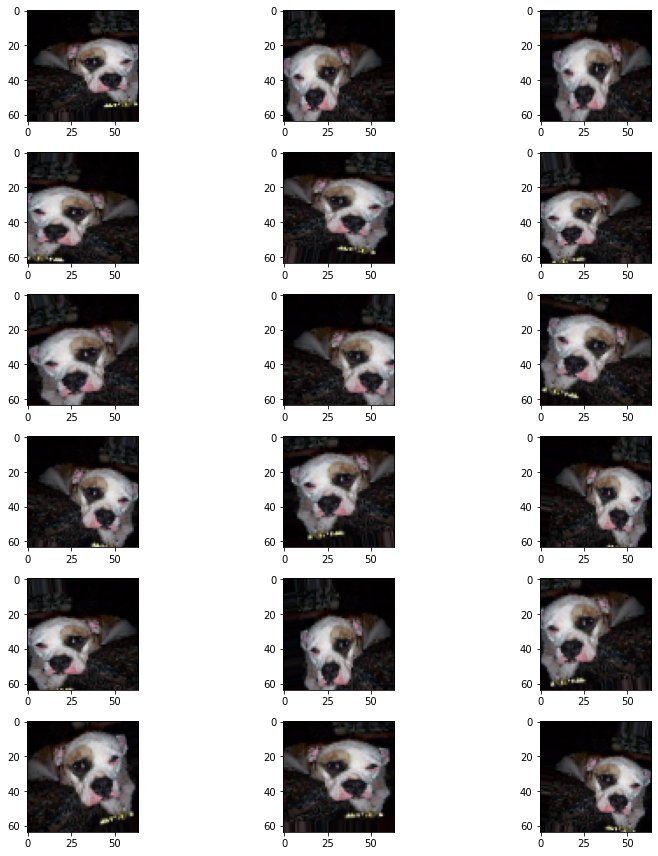

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 18):
    plt.subplot(6, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Model Training

In [23]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
  22/1500 [..............................] - ETA: 2:55 - loss: 0.3083 - accuracy: 0.8727

KeyboardInterrupt: 

### Save the Model

In [24]:
model

In [22]:
model.save("final_model.h5")

In [39]:
#from keras.models import load_model
#clf = load_model('model2.h5')

In [25]:
history.history

{'loss': [0.7344228029251099,
  0.5817059278488159,
  0.5355240702629089,
  0.5038296580314636,
  0.47741925716400146,
  0.4618418514728546,
  0.4413077235221863,
  0.4342120587825775,
  0.43218618631362915,
  0.39897364377975464,
  0.3856743574142456,
  0.38023507595062256,
  0.37612923979759216,
  0.3618060350418091,
  0.3539496660232544,
  0.34751394391059875,
  0.3485722541809082,
  0.3486623466014862,
  0.34548497200012207,
  0.3437865376472473,
  0.3387976288795471,
  0.3327282667160034,
  0.3279445171356201,
  0.3266517221927643,
  0.3267607092857361,
  0.32829901576042175,
  0.32517269253730774,
  0.32032525539398193,
  0.31994903087615967,
  0.3263629674911499,
  0.32271140813827515,
  0.32139772176742554,
  0.32090842723846436,
  0.33014407753944397,
  0.3179170489311218,
  0.31937122344970703,
  0.31690526008605957,
  0.3205398619174957,
  0.32042115926742554],
 'accuracy': [0.6311110854148865,
  0.704800009727478,
  0.735022246837616,
  0.7592889070510864,
  0.7792444229125

### Visualize Loss and Accuracy of Model

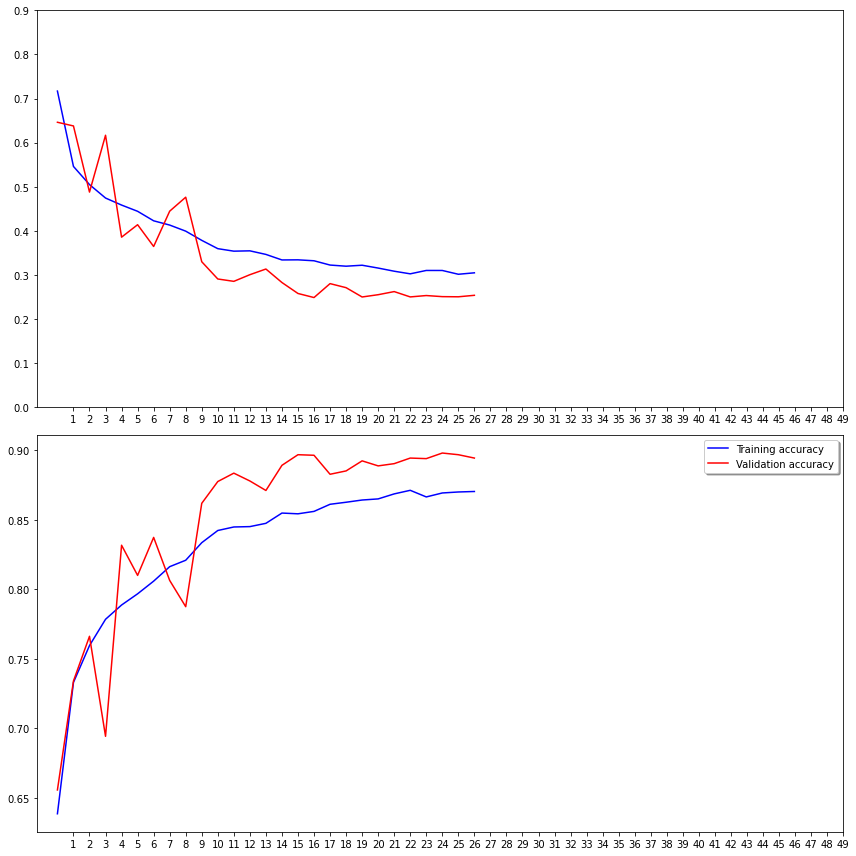

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Prepare Test Data

In [26]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


### Make Predictions

In [28]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))


In [29]:
test_df['category'] = np.argmax(predict, axis=-1)


In [30]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [31]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


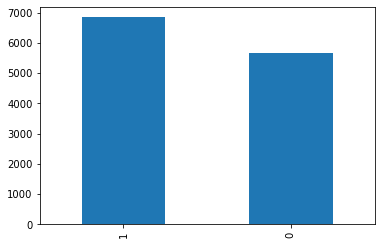

In [32]:
test_df['category'].value_counts().plot.bar()

### Visualize Predictions Results

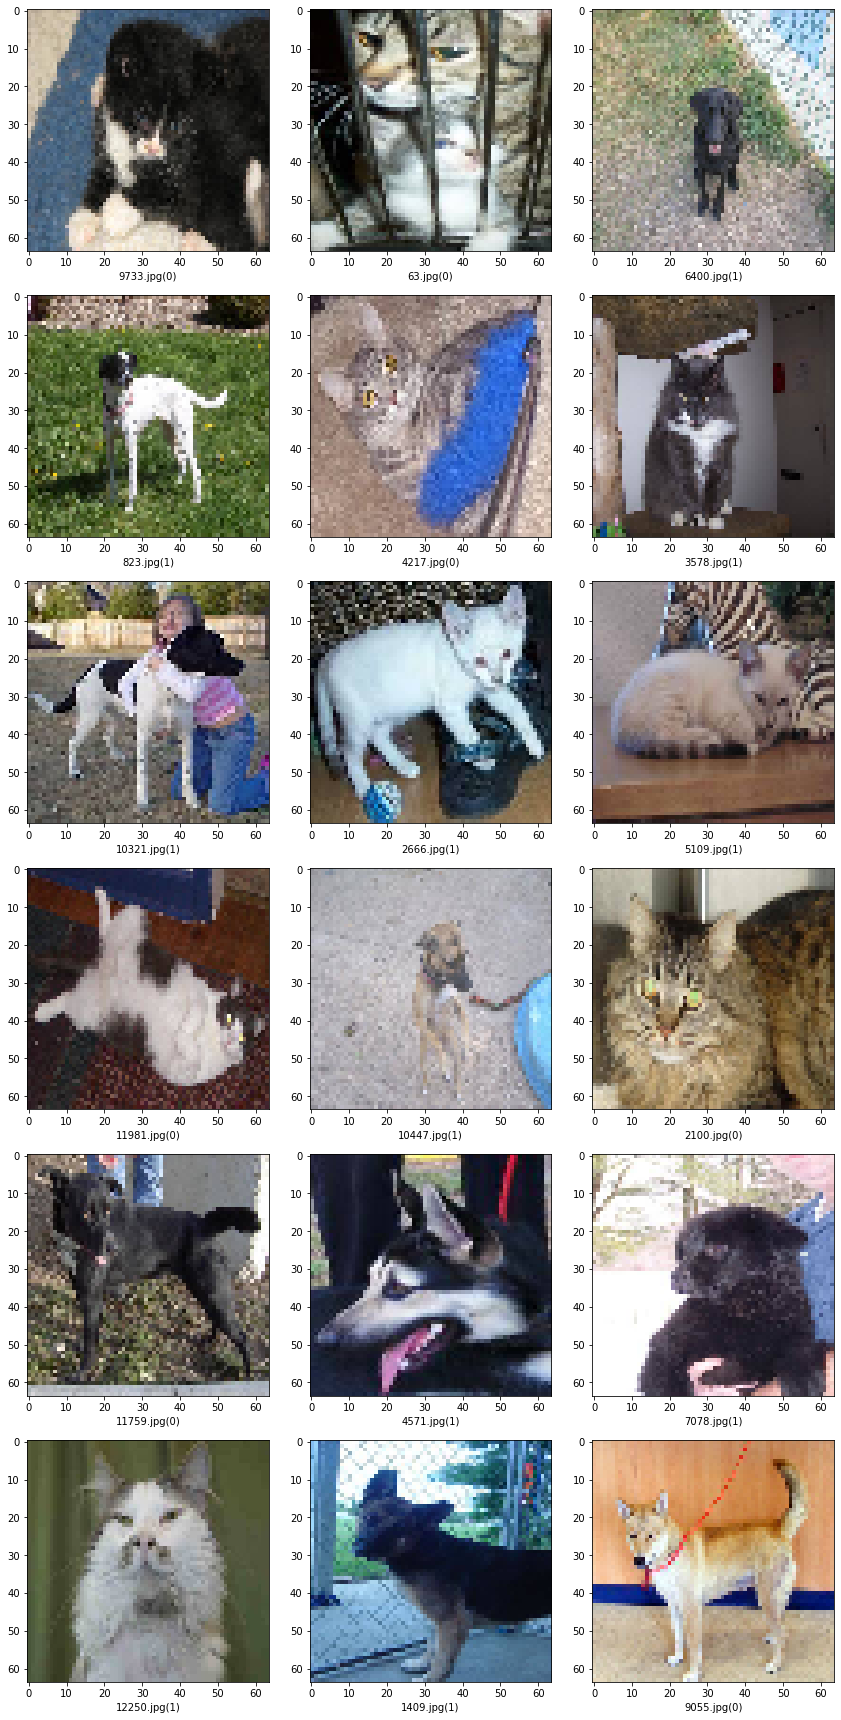

In [33]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### Test Model on Custom data

In [ ]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("__image_path_TO_custom_image")
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])

# Graphical User Interface with Tkinter

In [1]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
from keras.models import load_model
model = load_model('final_model.h5')
#dictionary to label all traffic signs class.
classes = { 
    0:'its a cat!',
    1:'its a dog!',
 
}
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Dogs VS Cats Classification IronHack')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((64,64))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict_classes([image])[0]
    sign = classes[pred]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#000000', foreground='black',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#000000', foreground='black',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Dogs VS Cats Classification IronHack",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
its a dog!
its a cat!
its a dog!
